In [1]:
import os
from skimage import io
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import shutil
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
batch_size = 32
img_height = 300
img_width = 200

In [3]:
num_classes = 3
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [4]:
def get_model_name():
    import time
    run=time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return run

In [5]:
recall=tf.keras.metrics.Recall(class_id=None)

In [6]:
root_logdir=os.path.join(os.curdir, 'my_logs')

In [7]:
def get_run_logdir():
    import time
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [8]:
run_logdir=get_run_logdir()

In [9]:
model_name=get_model_name()

In [10]:
model_name

'run_2021_01_09-18_43_19'

In [11]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-5 less"
        min_delta=1e-5,
        # "no longer improving" being further defined as "for at least 30 epochs"
        patience=30,
        verbose=1,), 
    keras.callbacks.TensorBoard(run_logdir,
                              histogram_freq=2,
                              write_graph=True,
                              write_images=True),
    keras.callbacks.ModelCheckpoint(filepath='models/'+model_name ,save_best_only=True)]

In [12]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, fill_mode='nearest', cval=0.0,
    horizontal_flip=True, vertical_flip=False)
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator()

In [13]:
train_generator = train_datagen.flow_from_directory(
        'plants/train',
        target_size=(300, 200),
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'plants/val',
        target_size=(300, 200),
        batch_size=32,
        class_mode='categorical')

Found 1968 images belonging to 3 classes.
Found 422 images belonging to 3 classes.


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[recall])

In [15]:
epochs=200
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs,
    callbacks=[callbacks])

Epoch 1/200
 1/62 [..............................] - ETA: 0s - loss: 1.1446 - recall: 0.0000e+00WARNING:tensorflow:From /Users/johnwilliams/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
62/62 [==============================] - ETA: 0s - loss: 0.8328 - recall: 0.6717WARNING:tensorflow:From /Users/johnwilliams/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets writt

62/62 [==============================] - 89s 1s/step - loss: 0.6068 - recall: 0.7170 - val_loss: 0.6678 - val_recall: 0.7085
Epoch 37/200
62/62 [==============================] - 90s 1s/step - loss: 0.6179 - recall: 0.7180 - val_loss: 0.6746 - val_recall: 0.6872
Epoch 38/200
62/62 [==============================] - 91s 1s/step - loss: 0.5926 - recall: 0.7287 - val_loss: 0.6518 - val_recall: 0.7038
Epoch 39/200
62/62 [==============================] - 91s 1s/step - loss: 0.5964 - recall: 0.7185 - val_loss: 0.6634 - val_recall: 0.7133
Epoch 40/200
62/62 [==============================] - 91s 1s/step - loss: 0.5878 - recall: 0.7241 - val_loss: 0.6415 - val_recall: 0.7133
Epoch 41/200
62/62 [==============================] - 91s 1s/step - loss: 0.5883 - recall: 0.7337 - val_loss: 0.6524 - val_recall: 0.7251
Epoch 42/200
62/62 [==============================] - 90s 1s/step - loss: 0.5880 - recall: 0.7368 - val_loss: 0.6776 - val_recall: 0.7417
Epoch 43/200
62/62 [===========================

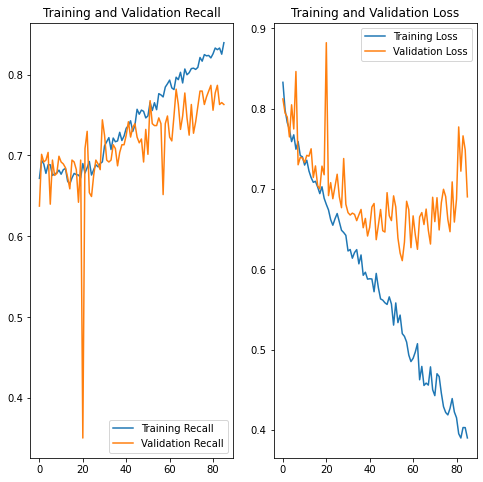

In [17]:
acc = history.history['recall']
val_acc = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Recall')
plt.plot(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('graphs/simplemodel64.png', bbox_inches='tight')
plt.show()

In [18]:
test_generator = test_datagen.flow_from_directory(
        'plants/test',
        target_size=(300, 200),
        batch_size=16,
        shuffle=False,
        class_mode='categorical')

Found 424 images belonging to 3 classes.


In [19]:
ben_plants = os.listdir('plants/test/Benign_Plants')
ivy=os.listdir('plants/test/Poison_Ivy/')
oak=os.listdir('plants/test/Poison_Oak')

In [20]:
y_true=pd.DataFrame()
for i in range(len(ben_plants)):
    num=pd.Series([1,0,0])
    y_true= y_true.append(num, ignore_index=True)
for j in range(len(ivy)):
    num=pd.Series([0,1,0])
    y_true= y_true.append(num, ignore_index=True)
for k in range(len(oak)):
    num=pd.Series([0,0,1])
    y_true= y_true.append(num, ignore_index=True)

In [21]:
y_hat=(model.predict(test_generator, verbose=1))

27/27 [==============================] - 5s 174ms/step


In [22]:
y_pred=np.argmax(y_hat, axis=1)
y_s=np.argmax(np.array(y_true), axis=1)

In [23]:
c_mat=confusion_matrix(y_s, y_pred)

In [24]:
percent=(c_mat/(np.sum(c_mat, axis=1).reshape(3,-1))).reshape(3,3)

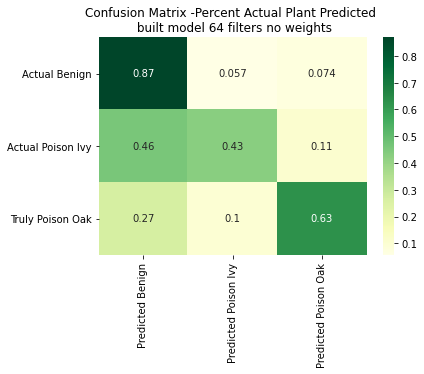

In [26]:
predicted_cat=['Predicted Benign', 'Predicted Poison Ivy', 'Predicted Poison Oak']
real_cat=['Actual Benign', 'Actual Poison Ivy', 'Truly Poison Oak']
sns.heatmap(percent, annot=percent, cmap='YlGn', 
            xticklabels=predicted_cat, 
            yticklabels=real_cat).set_title('Confusion Matrix -Percent Actual Plant Predicted \n built model 64 filters no weights');
plt.savefig('graphs/simplemodel64_2.png', bbox_inches='tight')